# Stochastic Model 03: Algoritmus MCMC (Přímé vzorkování)

In [1]:
# Instalace potřebných knihoven
#%pip install pandas
#%pip install numpy
#%pip install seaborn matplotlib

In [2]:
# Import potřebných knihoven
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

### Načtení přechodové matice

In [3]:
# Soubor je načten a přiřazen do proměnné ‚df‘
other_path = '../../data/model/transition_matrix.csv'
df = pd.read_csv(other_path, header=0)
P = df.to_numpy()
P

array([[0.00000000e+00, 9.98657124e-01, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        4.87149817e-05, 1.21787454e-03, 6.93511892e-06, 6.93511892e-05],
       [0.00000000e+00, 0.00000000e+00, 9.98657124e-01, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        4.87149817e-05, 1.21787454e-03, 6.93511892e-06, 6.93511892e-05],
       [0.00000000e+00, 0.00000000e+00, 7.48655318e-01, 2.50000000e-01,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        4.87804878e-05, 1.21951220e-03, 6.94444444e-06, 6.94444444e-05],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 4.98655318e-01,
        5.00000000e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        4.87804878e-05, 1.21951220e-03, 6.94444444e-06, 6.94444444e-05],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        6.65321985e-01, 3.33333333e-01, 0.00000000e+00, 0.00

### Parametry simulace

In [4]:
n_states = 12

# počet iteračních kroků (sekund)
n_iter = 1_000_000

# nastavení seedu (počátečního stavu generátoru náhodných čísel)
rng = np.random.default_rng(seed=122)

samples = np.zeros(n_iter, dtype=int)

# počáteční stav S1 (index 0)
current_state = 0
samples[0] = current_state

### Přímé vzorkování z přechodové matice

In [ ]:
for t in range(1, n_iter):

    current_state = rng.choice(
        n_states,
        p=P[current_state]
    )

    samples[t] = current_state

### Výsledná trajektorie stavů

In [6]:
# převod na stavy S1–S12
states = samples + 1

### Empirické rozdělení

In [7]:
hist = np.bincount(samples, minlength=n_states)
empirical_pi = hist / np.sum(hist)

print("Empirické rozdělení:")
print(empirical_pi)

Empirické rozdělení:
[0.019898 0.019866 0.079479 0.039166 0.058999 0.251703 0.076208 0.244172
 0.016793 0.110242 0.031284 0.05219 ]


### Sloupcový density graf

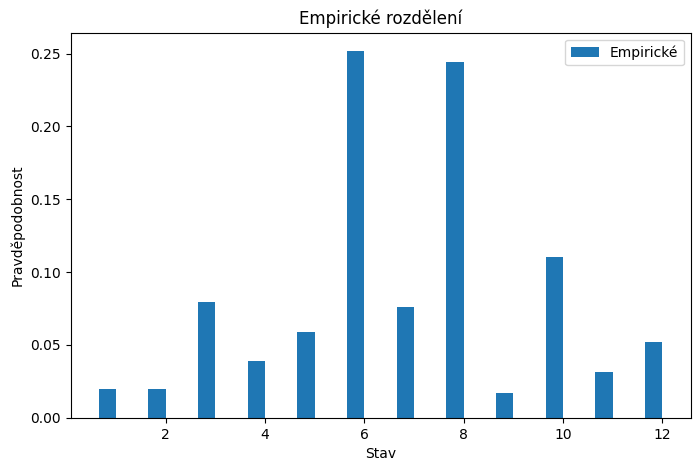

In [8]:
width = 0.35
states = np.arange(1,13)
plt.figure(figsize=(8,5))

plt.bar(states - width/2, empirical_pi, width, label='Empirické')

plt.xlabel("Stav")
plt.ylabel("Pravděpodobnost")
plt.title("Empirické rozdělení")
plt.legend()
plt.show()

### Ilustrační graf simulace

In [9]:
time = np.arange(len(samples))
states = samples + 1   # převod na S1–S12

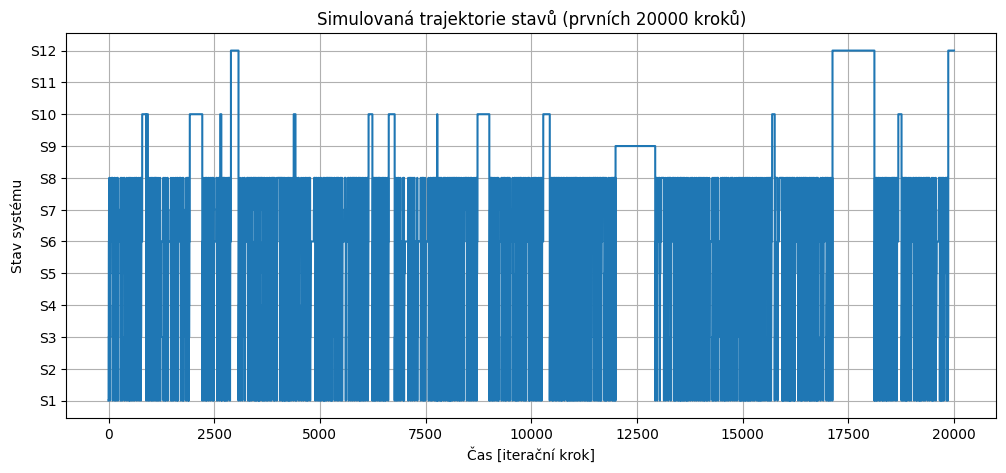

In [10]:
N = 20_000

plt.figure(figsize=(12,5))
plt.step(time[:N], states[:N], where='post')

plt.xlabel("Čas [iterační krok]")
plt.ylabel("Stav systému")
plt.title(f"Simulovaná trajektorie stavů (prvních {N} kroků)")

plt.yticks(np.arange(1,13), [f"S{i}" for i in range(1,13)])
plt.grid(True)

plt.show()

### Spálení počáteční části simulace (Burn-in)

Počáteční transientní fáze simulace (burn-in) byla identifikována a odstraněna z další analýzy. Tato oblast je v grafu vyznačena červeně.

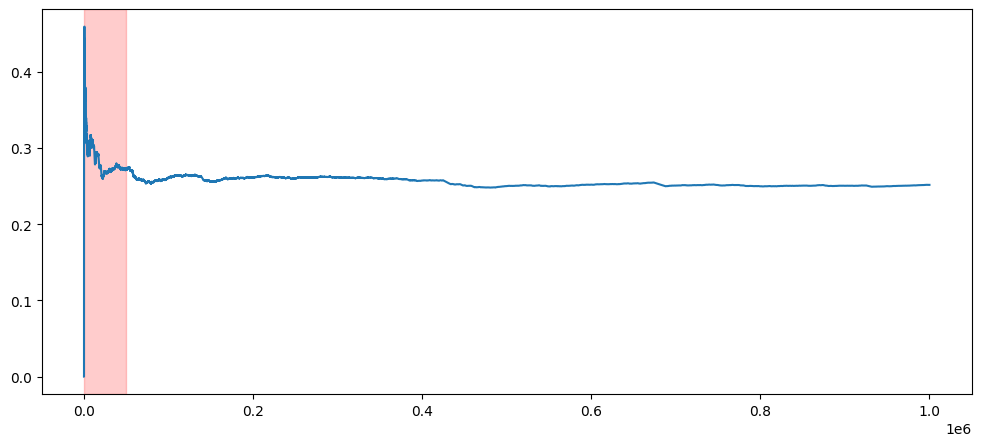

In [11]:
burn_in = 50_000
running_mean = np.cumsum(samples==5)/np.arange(1,len(samples)+1)
plt.figure(figsize=(12,5))
plt.axvspan(0, burn_in, color='red', alpha=0.2, label='Burn-in')
plt.plot(running_mean)

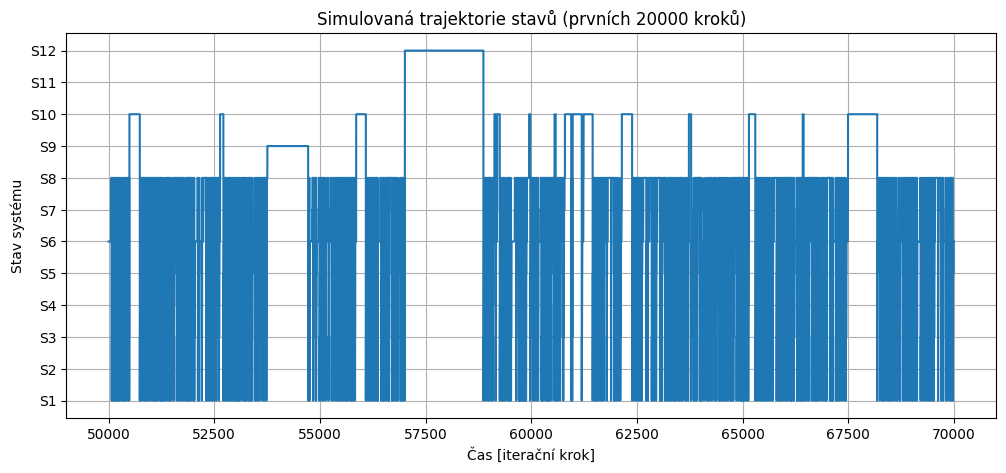

In [12]:

plt.figure(figsize=(12,5))
plt.step(time[burn_in:burn_in+N], states[burn_in:burn_in+N], where='post')

plt.xlabel("Čas [iterační krok]")
plt.ylabel("Stav systému")
plt.title(f"Simulovaná trajektorie stavů (prvních {N} kroků)")

plt.yticks(np.arange(1,13), [f"S{i}" for i in range(1,13)])
plt.grid(True)

plt.show()

### Odstranění burn-in

In [13]:
samples_burned = samples[burn_in:]

### Empirické rozdělení

In [14]:
hist = np.bincount(samples_burned, minlength=n_states)
empirical_pi = hist / np.sum(hist)

print("Empirické rozdělení:")
print(empirical_pi)

Empirické rozdělení:
[0.01984421 0.01981158 0.07932421 0.03907263 0.05886    0.25059579
 0.07574947 0.24442105 0.01668947 0.11052211 0.03293053 0.05217895]


### Sloupcový density graf

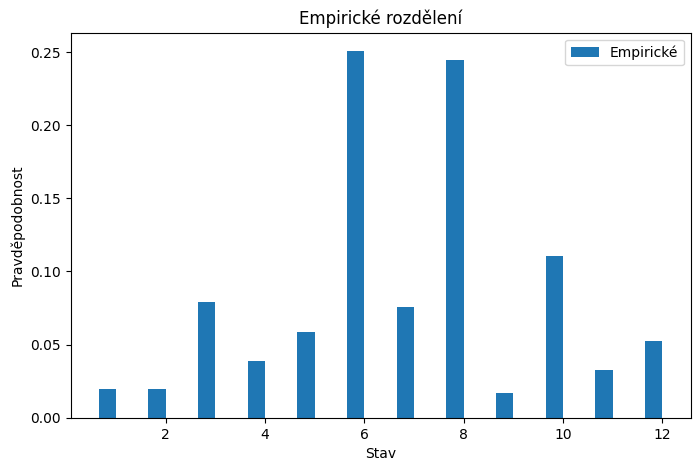

In [18]:
width = 0.35
states = np.arange(1,13)
plt.figure(figsize=(8,5))

plt.bar(states - width/2, empirical_pi, width, label='Empirické')

plt.xlabel("Stav")
plt.ylabel("Pravděpodobnost")
plt.title("Empirické rozdělení")
plt.legend()
plt.show()

### Export matice formátu CSV

In [16]:
df_sim = pd.DataFrame({
    "time": np.arange(len(samples_burned)),
    "state_index": samples_burned,
    "state": samples_burned + 1
})

In [17]:
df_sim.to_csv('../../data/model/simulation_MCMC_samples.csv', index=False)

### Autor / Organizace / Datum

Vjačeslav Usmanov, ČVUT v Praze, Fakulta stavební

###### Přehled změn


|  Datum (YYYY-MM-DD) |  Verze | Autor změny  |  Popis změny |
|---|---|---|---|
| 2026-01-25 | 1.1 | Vjačeslav Usmanov| added SM_03_MCMC_samples.ipynb |
| 2026-02-15 | 1.2 | Vjačeslav Usmanov| changed SM_03_MCMC_samples.ipynb |